In [108]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import Counter
from itertools import product

from sys import path

path.append("../utils/")

from utils import get_datasets

In [126]:
DATASETS = ["webkb", "20ng", "acm", "reut"]

CLFS = ["rep_bert", "sfr", "lpr", "ltr", "xtmk"]

In [127]:
pd_datasets = get_datasets(DATASETS)

In [129]:
d_probas = {}
for dset in DATASETS:
    d_probas[dset] = {}
    for clf in CLFS:
        lprobas = []
        for fold in np.arange(10):
            probs_path = f"/home/welton/data/clfs_output/split_10/{dset}/10_folds/{clf}/{fold}/test.npz"
            lprobas.append(np.load(probs_path)["X_test"])
        d_probas[dset][clf] = np.vstack(lprobas)

In [130]:
def plot_bar(probas, hits):
    unique, counts = np.unique(probas, return_counts=True)
    pcount = dict(zip(unique, counts))

    y1 = []; y2 = []
    keys = list(pcount.keys())
    keys.sort()
    labels = []
    for key in keys:
        y1.append(pcount[key])
        y2.append( hits[key] if key in hits else 0 )
        labels.append(f"{key} - {np.round(key + 0.1, decimals=1)}")
    x = np.arange(len(y1))

    plt.bar(x, y1, alpha=0.5, label="Prob. Freq.")
    plt.bar(x, y2, alpha=0.5, label="Hits")
    _ = plt.xticks(ticks=x, labels=labels, rotation=90)
    plt.legend(fontsize=14)

In [131]:
def plot_proba_dist(d_probas, pd_datasets, dset, clf):
    pred = d_probas[dset][clf].argmax(axis=1)
    probas = []
    hits = {}
    df = pd_datasets[dset]
    for idx, pclass in enumerate(pred):
        bean = np.trunc(d_probas[dset][clf][idx][pclass] * 10) / 10
        probas.append( 0.9 if bean >= 1 else bean )
        if pclass == df.classes.values[idx]:
            if bean not in hits:
                hits[bean] = 0
            hits[bean] += 1
    
    plot_bar(probas, hits)


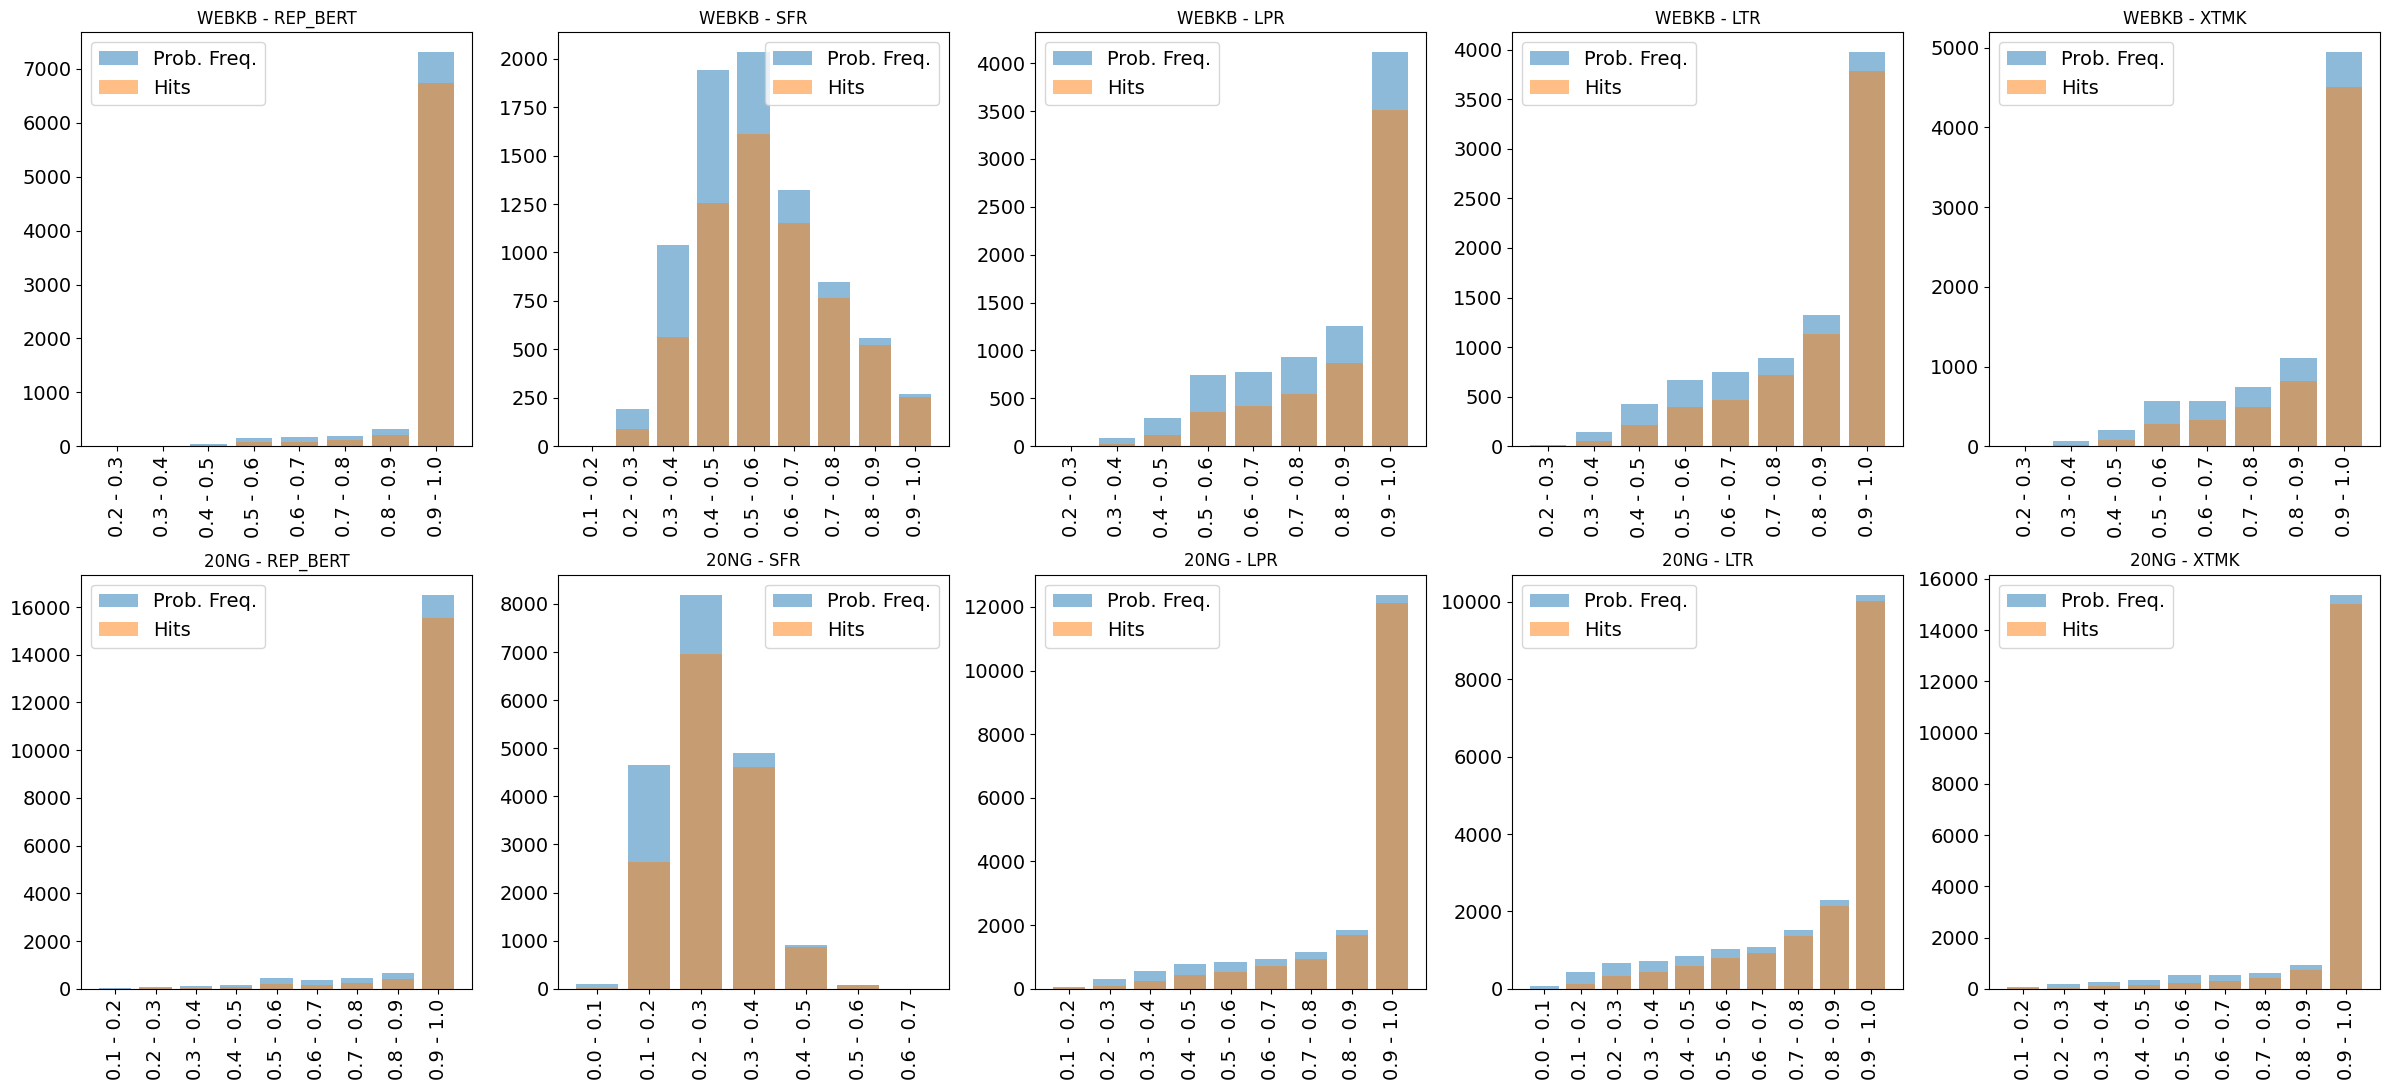

In [133]:
grid_data = ["webkb", "20ng"]
plt.figure(figsize=(24, 11))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS)):
    plt.subplot(len(grid_data), len(CLFS), plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()

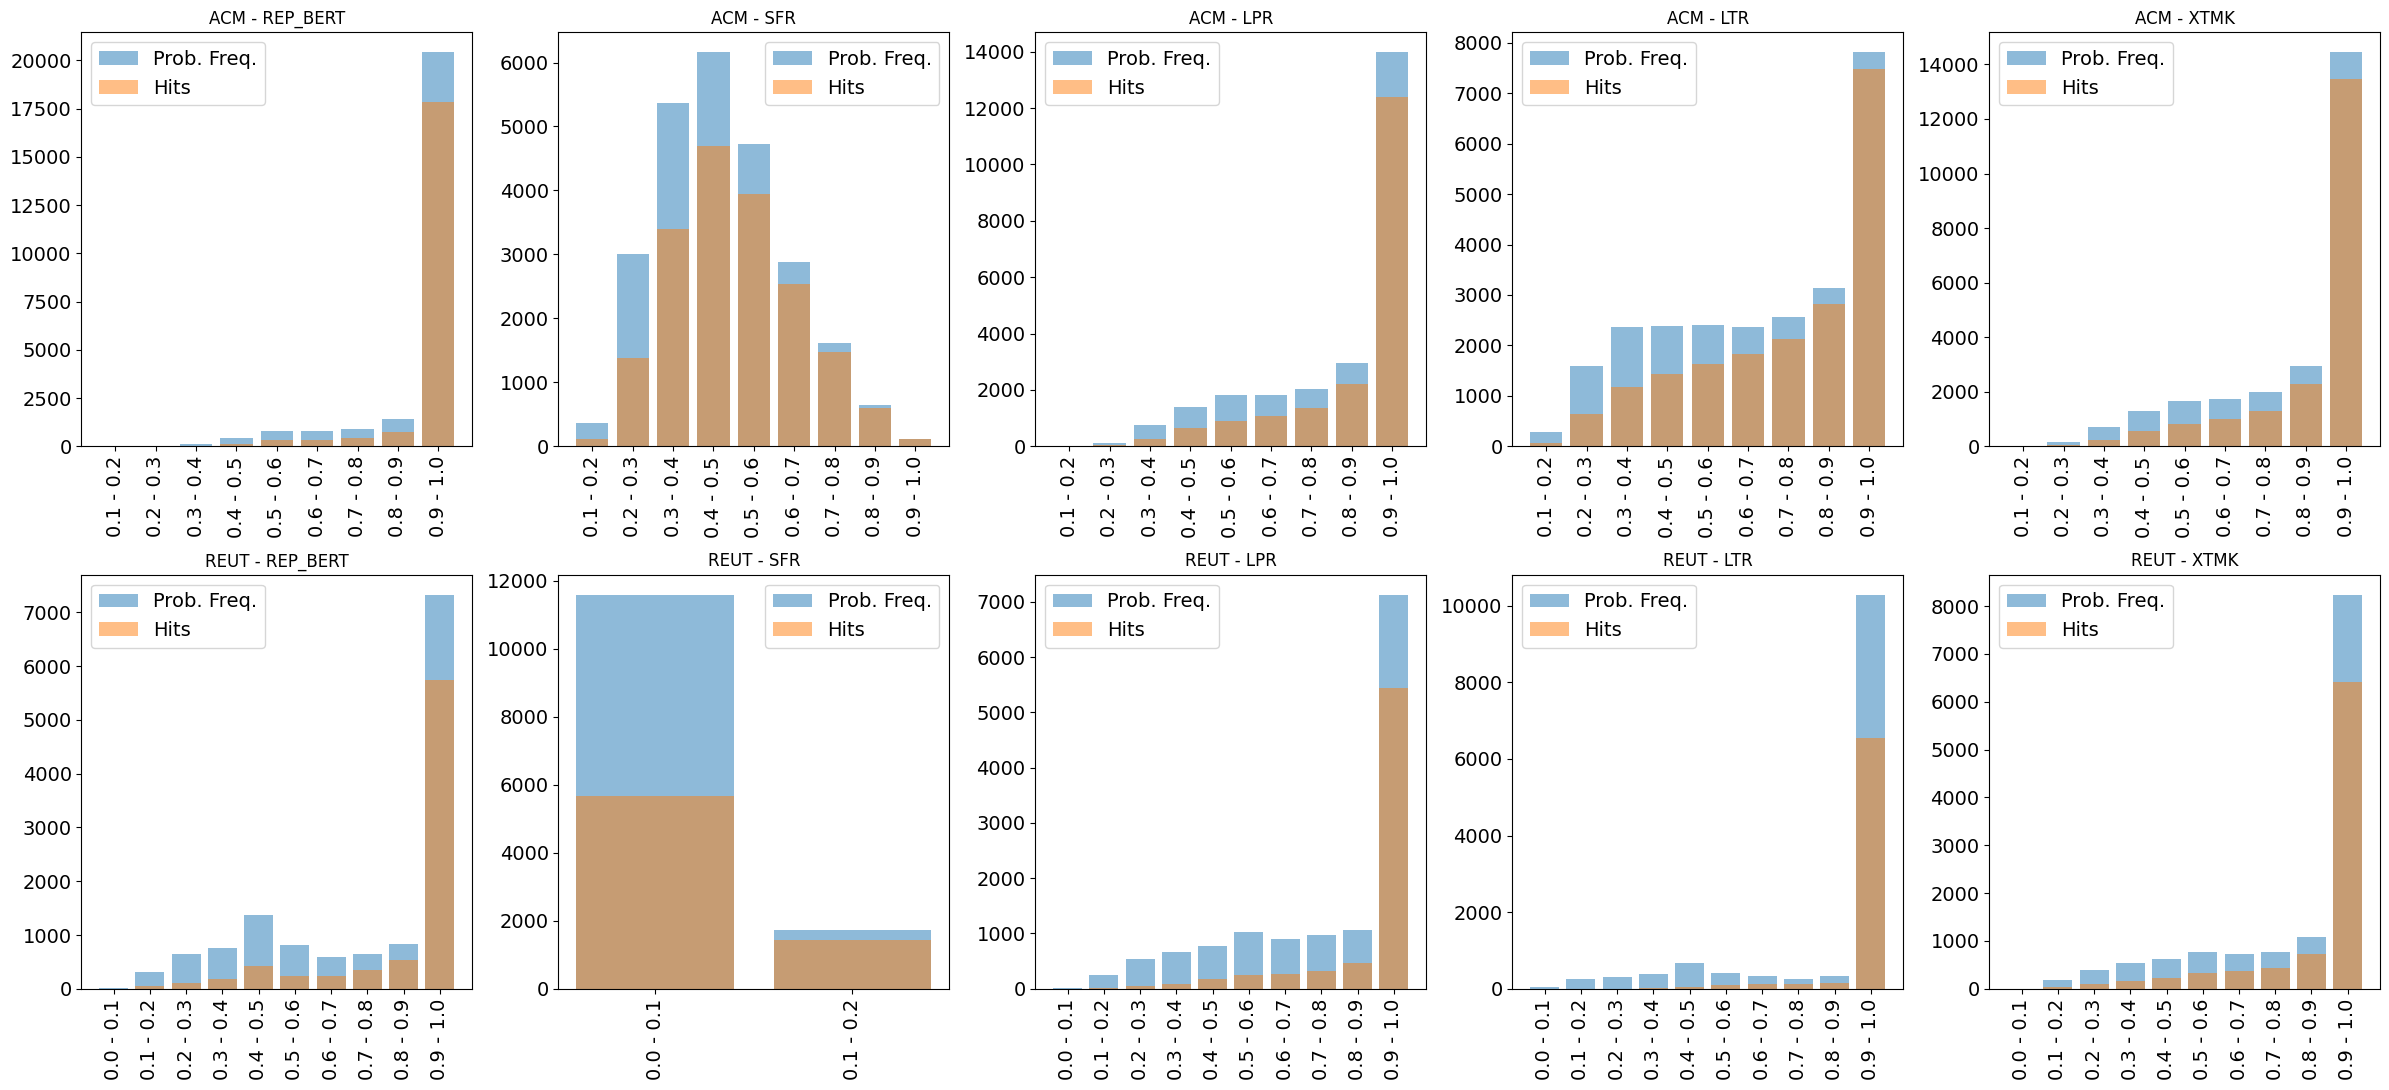

In [134]:
grid_data = ["acm", "reut"]
plt.figure(figsize=(24, 11))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS)):
    plt.subplot(len(grid_data), len(CLFS), plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()